In [1]:
#import packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib qt
%matplotlib inline

In [2]:
#number of corners in x and y direction on chessboard used for calibration
nx = 9
ny = 6

#read calibration images
images_calib = glob.glob('./camera_cal/calibration*.jpg')

#corner coordinates of real undistorted chessboard
objpoints = []

#corner coordinates of the 2D chessboard
imgpoints = []

#generate xy coordinates for object points
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

image_name = 'image8/'

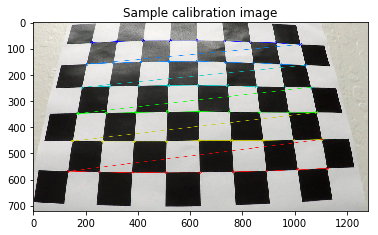

In [3]:
#read in images
for fname in images_calib:
    calib_img = mpimg.imread(fname)
    gray = cv2.cvtColor(calib_img, cv2.COLOR_RGB2GRAY)
#find corners    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
#draw corners
        calib_img = cv2.drawChessboardCorners(calib_img, (nx, ny), corners, ret)
        plt.title('Sample calibration image')
        plt.imshow(calib_img)
        mpimg.imsave('./output_images/' + image_name + 'calibration_img.png', calib_img)

In [4]:
#function to calibrate and undistort an image
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(calib_img, cv2.COLOR_RGB2GRAY)
#calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)  
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

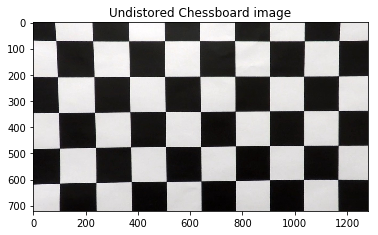

In [5]:
#check calibration and undistortion
img = mpimg.imread('./camera_cal/calibration1.jpg')
undist = cal_undistort(img, objpoints, imgpoints)
plt.title('Undistored Chessboard image')
plt.imshow(undist)
mpimg.imsave('./output_images/' + image_name + 'undistort_chessboard.png', undist)

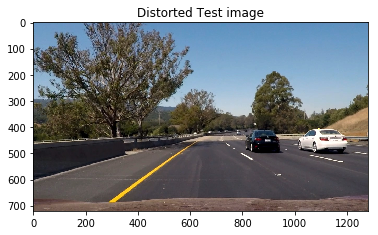

In [6]:
#Read in Lane image
filename = './test_images/test6.jpg'
img = mpimg.imread(filename)
plt.title('Distorted Test image')
plt.imshow(img)

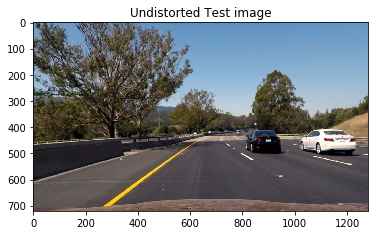

In [7]:
#Undistort source image
undist = cal_undistort(img, objpoints, imgpoints)
plt.title('Undistorted Test image')
plt.imshow(undist)
mpimg.imsave('./output_images/' + image_name + 'undistorted_src_img.png', undist)

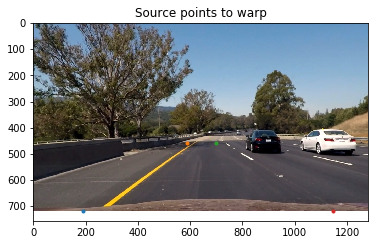

In [8]:
#Define src points to warp
plt.title('Source points to warp')
plt.imshow(undist)
plt.plot(190, 720, '.')
plt.plot(589, 457, '.')
plt.plot(698, 457, '.')
plt.plot(1145, 720, '.')

plt.savefig('./output_images/' + image_name + 'src_warp_points.png')

In [9]:
#function to warp image
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
        
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])  
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped, Minv

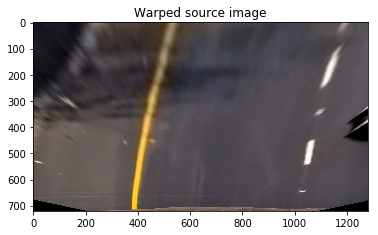

In [10]:
warped, Minv = warp(undist)
plt.title('Warped source image')
plt.imshow(warped)
mpimg.imsave('./output_images/' + image_name + 'warped_img.png', warped)

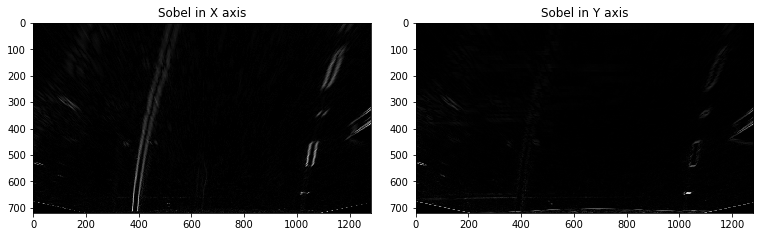

In [11]:
#Gradient thresholding
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobelx)
scaled_sobelx = np.uint(255 * abs_sobelx/ np.max(abs_sobelx))

sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
abs_sobely = np.absolute(sobely)
scaled_sobely = np.uint(255 * abs_sobely/ np.max(abs_sobely))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 9))
f.tight_layout()
ax1.imshow(scaled_sobelx, cmap = 'gray')
ax1.set_title('Sobel in X axis', fontsize=12)
ax2.imshow(scaled_sobely, cmap='gray')
ax2.set_title('Sobel in Y axis', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

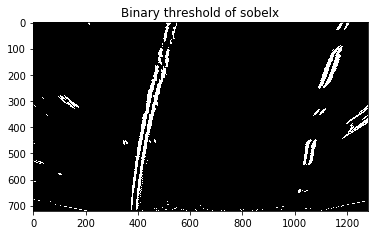

In [12]:
#thresholding sobelx
thresh_min = 20
thresh_max = 255

sxbinary = np.zeros_like(scaled_sobelx)
sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1
plt.title('Binary threshold of sobelx')
plt.imshow(sxbinary, cmap = 'gray')

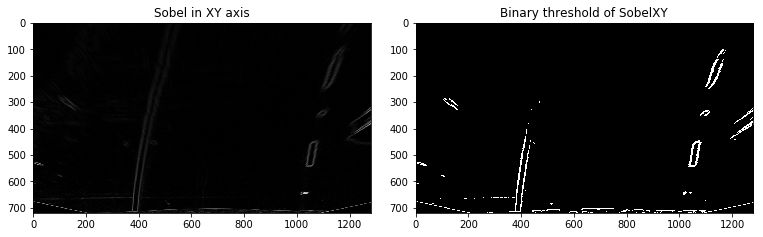

In [13]:
#thresholding - gradient magnitude
abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
scaled_sobelxy = np.uint(255 * abs_sobelxy/ np.max(abs_sobelxy))

thresh_min = 25
thresh_max = 180

sxybinary = np.zeros_like(scaled_sobelx)
sxybinary[(scaled_sobelxy >= thresh_min) & (scaled_sobelxy <= thresh_max)] = 1


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 9))
f.tight_layout()
ax1.imshow(scaled_sobelxy, cmap = 'gray')
ax1.set_title('Sobel in XY axis', fontsize=12)
ax2.imshow(sxybinary, cmap='gray')
ax2.set_title('Binary threshold of SobelXY', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

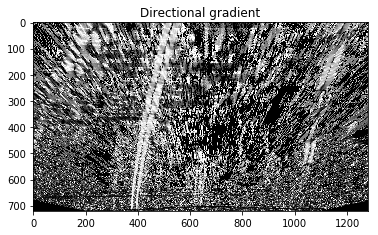

In [14]:
#thresholding - directional gradient
dir_sobel = np.arctan2(abs_sobelx, abs_sobely)
plt.title('Directional gradient')
plt.imshow(dir_sobel, cmap = 'gray')
plt.show()

#did not seem to add additional info on image

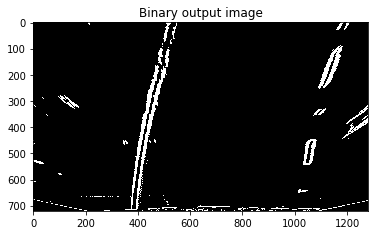

In [15]:
#Combining all binary output
gr_binary_output = np.zeros_like(scaled_sobelx)
gr_binary_output[(sxbinary == 1) | (sxybinary == 1)] = 1

plt.title('Binary output image')
plt.imshow(gr_binary_output, cmap = 'gray')


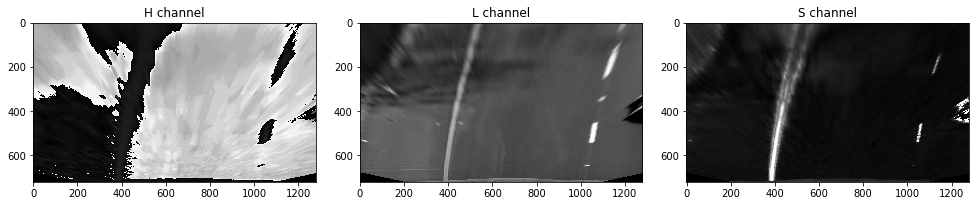

In [16]:
#Color space thresholding
hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(13, 12))
f.tight_layout()
ax1.imshow(H, cmap = 'gray')
ax1.set_title('H channel', fontsize=12)
ax2.imshow(L, cmap='gray')
ax2.set_title('L channel', fontsize=12)
ax3.imshow(S, cmap='gray')
ax3.set_title('S channel', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

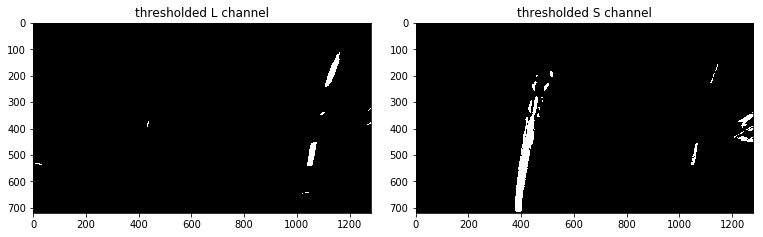

In [17]:
#thresholding
thresh_min = 180
thresh_max = 255

L_binary_output = np.zeros_like(L)
L_binary_output[(L >= thresh_min) & (L <= thresh_max)] = 1

thresh_min = 120
thresh_max = 255

S_binary_output = np.zeros_like(S)
S_binary_output[(S >= thresh_min) & (S <= thresh_max)] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2,  figsize=(10, 19))
f.tight_layout()
ax1.imshow(L_binary_output, cmap = 'gray')
ax1.set_title('thresholded L channel', fontsize=12)
ax2.imshow(S_binary_output, cmap='gray')
ax2.set_title('thresholded S channel', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

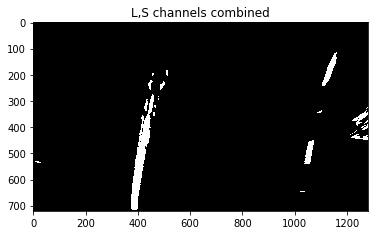

In [18]:
#Combine LS channels
cl_binary_output = np.zeros_like(S) 
cl_binary_output[(L_binary_output == 1) | (S_binary_output == 1)] = 1
plt.title('L,S channels combined') 
plt.imshow(cl_binary_output, cmap = 'gray')

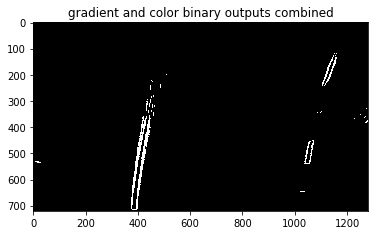

In [19]:
#Combine gradient and color binary outputs
binary_output = np.zeros_like(S)
binary_output[(gr_binary_output == 1)& (cl_binary_output == 1)] = 1
#binary_output[(cl_binary_output == 1)] = 1
plt.title('gradient and color binary outputs combined')
plt.imshow(binary_output, cmap = 'gray')

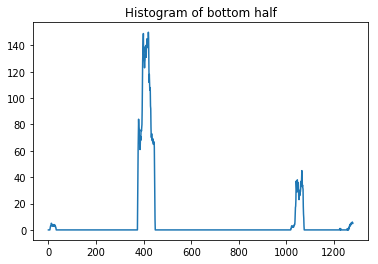

In [20]:
#Histogram along all the columns in the lower half of the image
histogram = np.sum(binary_output[np.int(binary_output.shape[0]/2):,:], axis = 0)
plt.title('Histogram of bottom half')
plt.plot(histogram)

plt.savefig('./output_images/' + image_name + 'histogram.png')

In [21]:
#Create an output image to draw on and visualize the result
out_img = np.dstack((binary_output, binary_output, binary_output))*255

#find peaks of the left and right halves of the histogram
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#Window params
nwindows = 9
window_height = np.int(binary_output.shape[0]/nwindows)
margin = 100
#min no.of px found to recenter window
minpix = 50

#Identify x and y pos of all non zero px in the image
nonzero = binary_output.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

#Set current pos of window
leftx_current = leftx_base
rightx_current = rightx_base

#Create empty list to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

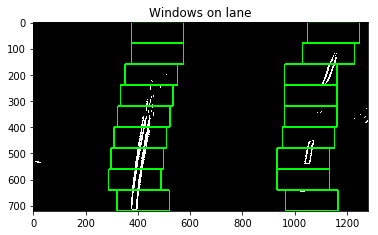

In [22]:
#Step through layers
for window in range(nwindows):
    win_y_low = binary_output.shape[0] - (window + 1) * window_height
    win_y_high = binary_output.shape[0] - window * window_height

#left lane window boundary
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    
#right lane window boundary
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
#draw window
    cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 3)
    cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 3)
    
#Identify non zero pixels in x and y within windows
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
#Append these indices to the list
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
#recenter next window to the mean of indices found if pix > minpix
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                               
                            
plt.title('Windows on lane')
plt.imshow(out_img)

mpimg.imsave('./output_images/' + image_name + 'windows_lane.png', out_img)

In [23]:
#concatenate the array of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

#extract the left and right lane pixel pos
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]

rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

#fit a second order polynomial - gives the coefficients
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

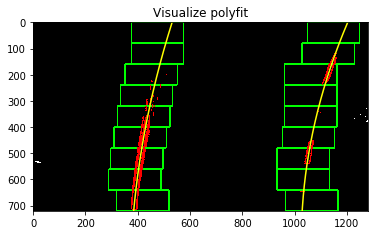

In [24]:
#Visualize the polyfit
ploty = np.linspace(0, binary_output.shape[0] - 1, binary_output.shape[0])

left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

#color pixels in window
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]

plt.title('Visualize polyfit')
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color = 'yellow')
plt.plot(right_fitx, ploty, color = 'yellow')

plt.xlim(0, 1280)
plt.ylim(720, 0)

mpimg.imsave('./output_images/' + image_name + 'polyfit.png', out_img)

In [25]:
#Warp back to the original image
def dewarp(image, undist,  warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result   

In [26]:
from measurements import find_curvature, dist_center, annotate
#import measurements as ms

902.008202914 m 552.874288765 m


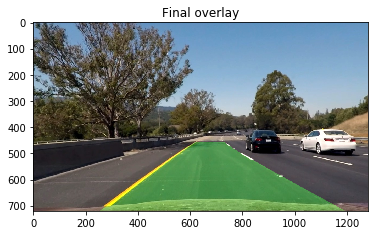

In [27]:
final = dewarp(img, undist, binary_output, Minv, left_fitx, right_fitx, ploty)
plt.title('Final overlay')
plt.imshow(final)

left_curverad, right_curverad, rad = find_curvature(ploty, leftx, rightx, lefty, righty)
print(left_curverad, 'm', right_curverad, 'm')

mpimg.imsave('./output_images/' + image_name + 'dewarp_overlay.png', final)

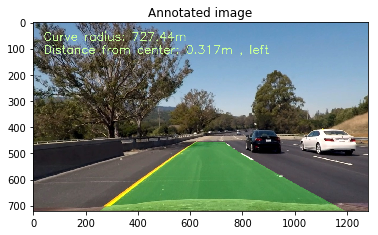

In [28]:
#annotate
d_center = dist_center(final, left_fit, right_fit, binary_output)
annotate_img = annotate(final, rad, d_center)
plt.title('Annotated image')
plt.imshow(annotate_img)

mpimg.imsave('./output_images/' + image_name + 'annotate.png', annotate_img)